In [92]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pickle as pkl
import urllib.request # to fetch data online
import re # regular expressions to parse html
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import seaborn as sns
sns.set(style="ticks");

In [97]:
%%capture 
%pylab inline
%load_ext autoreload
%autoreload 2
figsize(10,8) # in the global namespace when inline backend is in use.

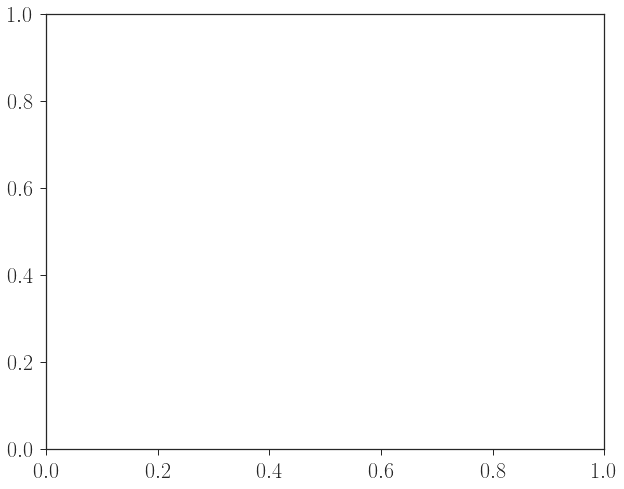

In [112]:
# Cosmetics
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0));
mpl.rcParams['xtick.labelsize'] = 32
mpl.rcParams['ytick.labelsize'] = 32
plt.rc('axes', labelsize=32)
plt.rc('legend', fontsize=22)
mpl.rcParams['ps.useafm'] = True
mpl.rcParams['pdf.use14corefonts'] = True
mpl.rcParams['text.usetex'] = True

## Download/read NIPS and JMLR data

In [26]:
# NIPS data in in ../data/papers.csv
bool_abstract_detected = False
bool_abstract_finished = False
nips_papers = []

tic = time.time()
with open("../data/papers.csv") as fin:
    lines = fin.readlines()
    for index, line in enumerate(lines):
        
        #print(line.split(','))
        
        if ".pdf," in line or "Abstract Missing" in line:
            # New entry detected, read paper id and year of publication
            line_split = line.split(',')
            paper_id = line_split[0]
            year = line_split[1]
        
        if bool_abstract_detected and not bool_abstract_finished:
            # Read new line of abstract and check whether it is the last one
            abstract += " "+line
            bool_abstract_finished = lines[index+1][-5:].isupper() or "Introduction" in lines[index+1]
            
        if bool_abstract_finished:
            # Save abstract and prepare for the next one
            paper = {}
            paper["id"] = paper_id
            paper["year"] = year
            paper["abstract"] = abstract
            nips_papers.append(paper)
            bool_abstract_detected = False
            bool_abstract_finished = False
        
        if line.startswith("ABSTRACT") or line.startswith("Abstract"):
            # New abstract starting next line
            abstract = ""
            bool_abstract_detected = True

toc = time.time()
number_of_papers = len(nips_papers)
print(str(number_of_papers)+" abstracts read in %0.3fs." % (toc-tic))

7234 abstracts read in 6.288s.


JMLR data has to be manually fetched. It takes some time, but I saved it as a pickle file in ../data. So load this if you don't want to wait.

In [2]:
volume_numbers = range(1,20)
jmlr_papers = []
tic = time.time()
for volume_number in volume_numbers:
    print("Reading volume", str(volume_number))

    # Read page listing papers in given volume
    volume_url = "http://www.jmlr.org/papers/v"+str(volume_number)
    html = urllib.request.urlopen(volume_url)
    page = html.read().decode('utf-8')
    
    # Find urls of abstracts
    candidate_patterns = [r"<a href=(.*)>\[abs\]</a>", r"<a href=(.*)>abs</a>"]
    #candidate_patterns = [r"<a href=(.*)>\[abs\]</a>", r"<a href=\"(.*)\">abs</a>", r"<a href=(.*)>abs</a>", r"<a href=\'(.*)\'>abs</a>"]
    cpt_patterns = 0
    paper_pattern = candidate_patterns[cpt_patterns]
    while re.search(paper_pattern, page) == None:     
        cpt_patterns += 1
        paper_pattern = candidate_patterns[cpt_patterns]
    papers_matches = re.finditer(paper_pattern, page)

    # Read abstract
    cpt = 0
    for paper_match in papers_matches:
        cpt += 1
        paper_id = paper_match.group(1)
        paper_id = paper_id.split('/')[-1] # some issues have full urls, so just keep the trailing id
        paper_id = paper_id.replace('\"',"")
        paper_id = paper_id.replace('\'',"")                            
        abstract_url = volume_url+'/'+paper_id            
        #if paper_id.startswith("http"):
            # some issues have full urls, some local urls"
        #    abstract_url = paper_id
        #elif paper_id.startswith("/papers"):
        #    temp = paper_id.split("/")
        #    abstract_url = paper_id
        #else:
        #    abstract_url = volume_url+'/'+paper_id
        #print(abstract_url)
        try:
            abstract_html = urllib.request.urlopen(abstract_url)
            abstract_page = abstract_html.read().decode('utf-8')
            #print(abstract_page)
            abstract_pattern = re.compile(r"<h3>Abstract</h3>(.*)<font", re.DOTALL) # DOTALL allows . to match with newlines
            abstract_match = re.search(abstract_pattern, abstract_page) 
            #print(abstract_match)
            #abstracts_matches = re.finditer(abstract_pattern, abstract_page)
            #for abstract_match in abstracts_matches:
            paper = {}
            paper["volume"] = volume_number
            paper["abstract"] = abstract_match.group(1).replace("\n","") # also replace <p>
            jmlr_papers.append(paper)  
        except:
            print("Dead link:", abstract_url)
            pass
    print(cpt, "papers in volume", volume_number)

toc = time.time()
number_of_jmlr_papers = len(jmlr_papers)
print(number_of_jmlr_papers, "papers read in %0.3fs."%(toc - tic))

Reading volume 1
11 papers in volume 1
Reading volume 2
32 papers in volume 2
Reading volume 3
56 papers in volume 3
Reading volume 4
54 papers in volume 4
Reading volume 5
31 papers in volume 5
Reading volume 6
73 papers in volume 6
Reading volume 7
100 papers in volume 7
Reading volume 8
91 papers in volume 8
Reading volume 9
95 papers in volume 9
Reading volume 10
100 papers in volume 10
Reading volume 11
118 papers in volume 11
Reading volume 12
105 papers in volume 12
Reading volume 13
119 papers in volume 13
Reading volume 14
Dead link: http://www.jmlr.org/papers/v14/debrabanter13a.html
121 papers in volume 14
Reading volume 15
120 papers in volume 15
Reading volume 16
Dead link: http://www.jmlr.org/papers/v16/feldman15a.html
118 papers in volume 16
Reading volume 17
238 papers in volume 17
Reading volume 18
234 papers in volume 18
Reading volume 19
84 papers in volume 19
1898 papers read in 465.666s.


In [4]:
pkl.dump(jmlr_papers, open("jmlr.pkl","wb"))

## A quick look at JMLR data

In [75]:
bayesian_jmlr_papers = []
neural_network_jmlr_papers = []
for paper in jmlr_papers:
    bayesian_keywords = ["Bayesian", "variational Bayes", "Carlo", "MCMC"]
    if any(kwd in paper["abstract"] for kwd in bayesian_keywords):
        bayesian_jmlr_papers.append(paper)
    neural_network_keywords = ["neural net", "Neural net", "deep", "Deep"]
    if any(kwd in paper["abstract"] for kwd in neural_network_keywords):
        neural_network_jmlr_papers.append(paper)
        
number_of_jmlr_papers = len(jmlr_papers)
number_of_Bayesian_jmlr_papers = len(bayesian_jmlr_papers)   
print("There are", str(len(neural_network_jmlr_papers))+" neural network papers out of", number_of_jmlr_papers)
print("There are", str(number_of_Bayesian_jmlr_papers)+" Bayesian papers out of", number_of_jmlr_papers)

There are 98 neural network papers out of 1898
There are 252 Bayesian papers out of 1898


In [76]:
# Bayesian networks may not be about Bayesian statistics
print("Out of which the number of papers about Bayesian networks is")
print(np.sum(["Bayesian network" in paper["abstract"] for paper in bayesian_jmlr_papers]))

Out of which the number of papers about Bayesian networks is
63


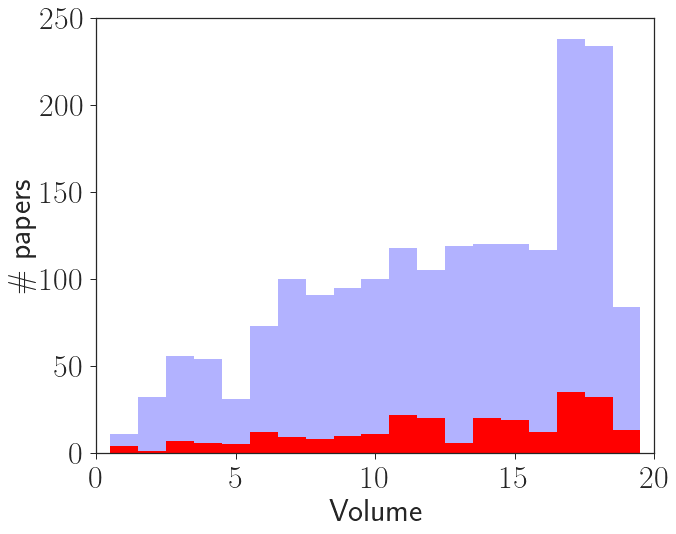

In [113]:
# plot proportion of Bayesian papers in JMLR
volumes = [int(paper["volume"]) for paper in jmlr_papers] + [20]
bins = np.unique(volumes) - .5
plt.hist([int(paper["volume"]) for paper in jmlr_papers], color="blue", bins=bins, alpha=.3)
bins = np.unique([int(paper["volume"]) for paper in jmlr_papers] + [20]) - .5
plt.hist([int(paper["volume"]) for paper in bayesian_jmlr_papers], color="red", bins=bins)
plt.xticks([5*i for i in range(6)])
#plt.title("# Bayesian papers in JMLR")
plt.xlabel("Volume")
plt.ylabel("\# papers")
plt.xlim([0,20])
plt.savefig("../figures/bayesianPapersJMLR.pdf")
plt.show()

## A quick look at Bayesian papers at NIPS 1985--2017

In [68]:
# Select Bayesian and neural papers
bayesian_nips_papers = []
neural_network_nips_papers = []
for paper in nips_papers:
    bayesian_keywords = ["Bayesian", "variational Bayes", "Carlo", "MCMC"]
    if any(kwd in paper["abstract"] for kwd in bayesian_keywords):
        bayesian_nips_papers.append(paper)
    neural_network_keywords = ["neural network", "Neural network", "deep", "Deep"]
    if any(kwd in paper["abstract"] for kwd in neural_network_keywords):
        neural_network_nips_papers.append(paper)
number_of_Bayesian_nips_papers = len(bayesian_nips_papers)   
print("There are", str(len(neural_network_nips_papers))+" neural network papers out of", number_of_papers)
print("There are", str(number_of_Bayesian_nips_papers)+" Bayesian papers out of", number_of_papers)

There are 1063 neural network papers out of 7234
There are 850 Bayesian papers out of 7234


In [69]:
# Bayesian networks may not be about Bayesian statistics
print("Out of which the number of papers about Bayesian networks is")
print(np.sum(["Bayesian network" in paper["abstract"] for paper in bayesian_nips_papers]))

Out of which the number of papers about Bayesian networks is
53


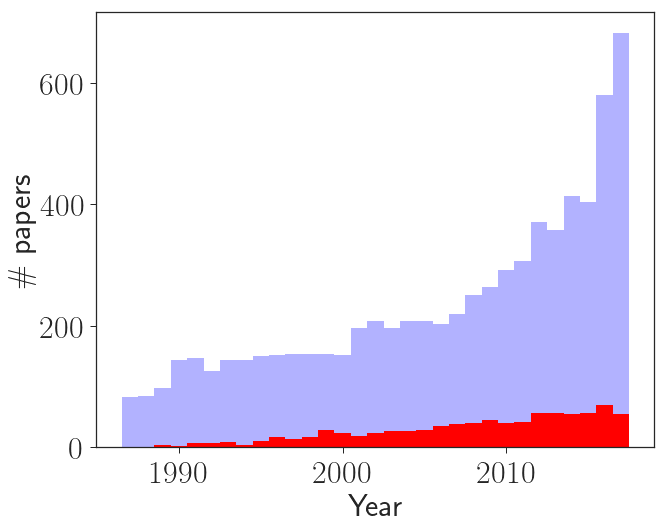

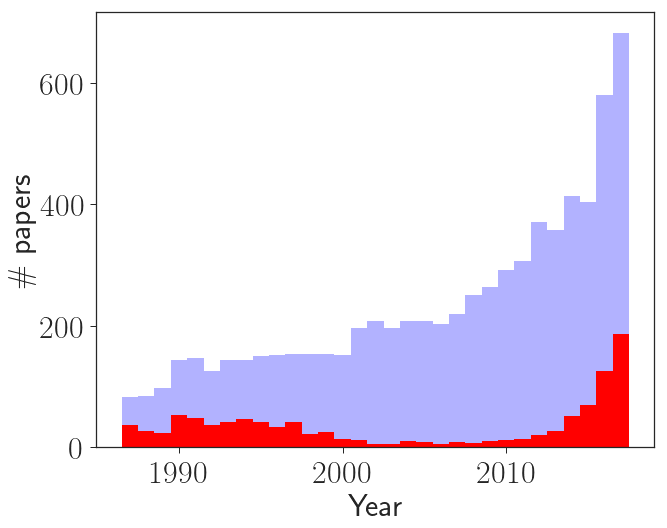

In [115]:
# plot proportion of Bayesian papers
years = [int(paper["year"]) for paper in nips_papers] + [2018]
bins = np.unique(years) - .5
plt.hist([int(paper["year"]) for paper in nips_papers], color="blue", bins=bins, alpha=.3)
bins = np.unique([int(paper["year"]) for paper in bayesian_nips_papers] + [2018]) - .5
plt.hist([int(paper["year"]) for paper in bayesian_nips_papers], color="red", bins=bins)
plt.xticks([1990+10*i for i in range(3)])
#plt.title("# Bayesian papers at NeurIPS conferences 1987-2017")
plt.xlabel("Year")
plt.ylabel("\# papers")
plt.savefig("../figures/bayesianPapersNIPS.pdf")
plt.show()

# plot proportion of NN papers
years = [int(paper["year"]) for paper in nips_papers] + [2018]
bins = np.unique(years) - .5
plt.hist([int(paper["year"]) for paper in nips_papers], color="blue", bins=bins, alpha=.3)
bins = np.unique([int(paper["year"]) for paper in neural_network_nips_papers] + [2018]) - .5
plt.hist([int(paper["year"]) for paper in neural_network_nips_papers], color="red", bins=bins)
plt.xticks([1990+10*i for i in range(3)])
#plt.title("# Deep papers at NeurIPS conferences 1987-2017")
plt.xlabel("Year")
plt.ylabel("\# papers")
plt.savefig("../figures/neuralPapersNIPS.pdf")
plt.show()

## Topic modelling

Let us first look at all JMLR

In [56]:
# Extract tf features (raw term counts)
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                max_features=1000,
                                stop_words='english') # output is a sparse matrix
tic = time.time()
tf = tf_vectorizer.fit_transform([paper["abstract"] for paper in jmlr_papers])
print("Extraction done in %0.3fs." % (time.time() - tic))

# Fit the LDA
number_of_topics = 10
lda = LatentDirichletAllocation(n_components=number_of_topics, max_iter=100,
                                learning_method='online',
                                learning_offset=50.,
                                doc_topic_prior= 1., 
                                random_state=0)
tic = time.time()
lda.fit(tf)
print("LDA fit done in %0.3fs." % (time.time() - tic))

Extraction done in 0.314s.
LDA fit done in 41.943s.


In [57]:
# Print top words in each topic
def print_top_words(model, feature_names, number_of_top_words=10):
    """print top words by topic in a given model
    """
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-number_of_top_words - 1:-1]])
        print(message)
    print()
       
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names)

Topic #0: matrix clustering low graph based random problem rank data results
Topic #1: sub sup algorithm convex problems loss problem regularization log bound
Topic #2: learning algorithms methods problems machine framework task tasks data large
Topic #3: models model em data bayesian variables inference networks network structure
Topic #4: algorithm algorithms learning gradient time optimal online stochastic policy based
Topic #5: estimation statistical information model estimator estimate function method level sample
Topic #6: kernel space functions kernels function gaussian support prior vector distributions
Topic #7: classification learning class training data error classifiers supervised risk examples
Topic #8: nbsp href papers pdf font bib target 17 right 100
Topic #9: data method selection high dimensional feature regression analysis features linear



Now only Bayesian papers

In [58]:
# Extract tf features (raw term counts)
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                max_features=1000,
                                stop_words='english') # output is a sparse matrix
tic = time.time()
tf = tf_vectorizer.fit_transform([paper["abstract"] for paper in bayesian_jmlr_papers])
print("Extraction done in %0.3fs." % (time.time() - tic))

# Fit the LDA
number_of_topics = 10
lda = LatentDirichletAllocation(n_components=number_of_topics, max_iter=100,
                                learning_method='batch',
                                learning_offset=50.,
                                doc_topic_prior= 1., 
                                random_state=0)
tic = time.time()
lda.fit(tf)
print("LDA fit done in %0.3fs." % (time.time() - tic))

Extraction done in 0.050s.
LDA fit done in 3.921s.


In [59]:
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names)

Topic #0: networks network structure time algorithm bayesian search variables structures learning
Topic #1: gaussian function bayesian functions process propose gp approach kernel gradient
Topic #2: model selection sup bayesian problem standard performance approach prior solution
Topic #3: learning bayesian use results different methods provide based bounds method
Topic #4: markov algorithm model based data present monte efficient inference chain
Topic #5: bayesian inference variational latent methods non models analysis model modeling
Topic #6: learning models algorithms optimization data multi present topic hidden available
Topic #7: data em method number model training sets statistical bayesian set
Topic #8: model models clustering analysis data probabilistic based used problem empirical
Topic #9: nbsp posterior data target mcmc inference href papers 17 bib



Now Bayesian papers in JMLR+NIPS

In [108]:
print(len(bayesian_jmlr_papers+bayesian_nips_papers))

1102


In [80]:
# Extract tf features (raw term counts)
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                max_features=1000,
                                stop_words='english') # output is a sparse matrix
tic = time.time()
tf = tf_vectorizer.fit_transform([paper["abstract"] for paper in bayesian_jmlr_papers+bayesian_nips_papers])
print("Extraction done in %0.3fs." % (time.time() - tic))

# Fit the LDA
number_of_topics = 10
lda = LatentDirichletAllocation(n_components=number_of_topics, max_iter=100,
                                learning_method='batch',
                                learning_offset=50.,
                                doc_topic_prior= 1., # alpha concentration parameter
                                random_state=0)
tic = time.time()
lda.fit(tf)
print("LDA fit done in %0.3fs." % (time.time() - tic))

Extraction done in 0.209s.
LDA fit done in 25.318s.


In [81]:
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, number_of_top_words=10)

Topic #0: model models data process latent bayesian dirichlet hierarchical nonparametric inference
Topic #1: features learn problem different knowledge learning image object example examples
Topic #2: method neural bayesian using linear state based kernel approach model
Topic #3: belief propagation nodes local tree posterior node nbsp given algorithm
Topic #4: learning data bayesian model training classification performance selection prediction sets
Topic #5: inference monte carlo markov sampling variational time algorithm mcmc approximate
Topic #6: function optimization algorithm optimal learning problem gradient methods bounds state
Topic #7: learning networks variables structure network bayesian em paper distribution algorithm
Topic #8: bayesian gaussian prior regression non estimation likelihood sparse parameters matrix
Topic #9: model information bayesian human visual task probability sensory prior concept

